# Preprocess Data

In [2]:
import pystan
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd
import seaborn

%matplotlib inline

In [3]:
### Import get columns and rows
data = pd.read_csv("co2.csv",sep=',', comment='"',header=None,names=["date", "co2"])
data["date"] = pd.to_datetime(data["date"])

# make column of years passed, for seasonal variation
data["years_passed"] = [(d-data["date"][0]).days/365.25 for d in data["date"]] 


In [4]:
data.tail()

,date,co2,years_passed
3134,2019-08-31,409.32,61.423682
3135,2019-09-07,408.80,61.442847
3136,2019-09-14,408.61,61.462012
3137,2019-09-21,408.50,61.481177
3138,2019-09-28,408.28,61.500342


In [5]:
# generate dates to predict
# from last day til 2058, weekly on saturday
pred_dates = pd.date_range("2019-09-29", "2058-01-01", freq='W-SAT')
pred_years_passed = [(d-data["date"][0]).days/365.25 for d in pred_dates] 

/usr/local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


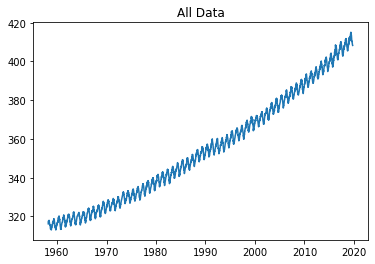

In [6]:
n = len(data)
n_future = len(pred_dates)

plt.plot(data["date"],data["co2"]);
plt.title("All Data");

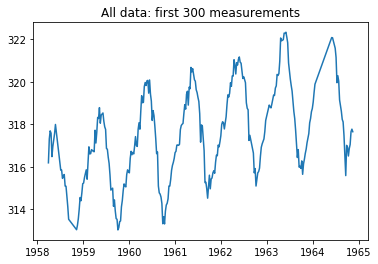

In [7]:
import matplotlib.dates as mdates

years = mdates.YearLocator()   # every year
years_fmt = mdates.DateFormatter('%Y')

fig, ax = plt.subplots()
ax.plot("date","co2",data=data[:300]);
ax.xaxis.set_major_locator(years);
ax.xaxis.set_major_formatter(years_fmt);
plt.title("All data: first 300 measurements");

# First Impressions

Generally linear trend with some type of compounding behavior. Either a quadratic or exponential

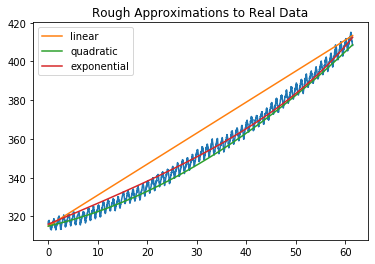

In [9]:
x = data["years_passed"]
plt.plot(x,data["co2"]);
plt.plot(x,[315+1.6*(i)for i in x],label="linear");
plt.plot(x,[315+0.6*(i) + 0.015*(i**2) for i in x], label="quadratic");
plt.plot(x,[315+1*(i) + 1.06**i for i in x], label="exponential");
plt.title("Rough Approximations to Real Data")
plt.legend();

# Model Fitting

In [111]:
# The Stan model. Running this cell compiles the Stan model, which takes
# some time.

stan_code = """
data {
    int<lower=0> n;        // The number of data
    int<lower=0> n_future;
    real x[n];             // The co2 data (observed)
    real<lower=0> time[n];  // Observed time (in years passed)
    real<lower=0> time_future[n_future];  // Unobserved time (in years passed)
}

parameters {
    // _____POLY_____
    real<lower=0> C0;                   // constant
    real<lower=0> C1;                   // x multiplier
    real<lower=0> C2;                   // x^2 multiplier
    
    // _____PERIODIC_____
    real<lower=0> A;           // amplitude
    real phi_x;                // dummy var for phi
    real phi_y;                // "               "
    
    // _____NOISE_____
    real<lower=0> sigma;

}

transformed parameters {
    // atan converts to range [-pi,pi]
    real phi = atan2(phi_x, phi_y); // offset for period
}

model {
    // _____PRIORS_____
    C0 ~ normal(300, 50);
    C1 ~ normal(0, 1);
    C2 ~ normal(0,1);
    A ~ normal(3,2);
    sigma ~ gamma(1, 0.3);
    
    // _____MODEL_____
    for(t in 1:n) {
        x[t] ~ normal(
            C0 + C1*time[t] + C2*time[t]^2 + A*cos(2*pi()*time[t] + phi),
            sigma^2);
    }
}

// Generate the predicted function values for the next n_future steps.
generated quantities {
    real x_future[n_future];
    for(t in 1:n_future) {
        x_future[t] = normal_rng(
            C0 + C1*(time_future[t]) + C2*(time_future[t])^2 + A*cos(2*pi()*time_future[t] + phi),
            sigma^2 + 0.001*t); // arbitrarily add a t factor in uncertainty to show growing uncertainty
    }
}

"""

stan_model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3b58f5748e9fcd298e691d605952347a NOW.


In [112]:
stan_data = {
    'n': n,
    'n_future': n_future,
    'x': data["co2"],
    'time': data["years_passed"],
    'time_future': pred_years_passed
} 

In [113]:
# Run Hamiltonian Monte Carlo using Stan with 4 Markov chains, a 1000 step
# warm-up phase and 1000 step sampling phase for each chain. The warm-up samples
# are discarded, so we are left with 4 x 1000 = 4000 samples.

# This cell will take a minute or two to run.

parameters = ['C0','C1','C2','A','phi','sigma']

results = stan_model.sampling(data=stan_data)
print(results.stansummary(pars=parameters))
samples = results.extract()

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Inference for Stan model: anon_model_3b58f5748e9fcd298e691d605952347a.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
C0    314.57  9.3e-4   0.05 314.46 314.53 314.57 314.61 314.67   3413    1.0
C1      0.77  7.0e-5 4.0e-3   0.76   0.77   0.77   0.77   0.78   3269    1.0
C2      0.01  1.1e-6 6.3e-5   0.01   0.01   0.01   0.01   0.01   3338    1.0
A       2.86  4.0e-4   0.02   2.81   2.84   2.86   2.88   2.91   3716    1.0
phi    -0.42  2.4e-4 8.8e-3  -0.43  -0.42  -0.42  -0.41   -0.4   1315    1.0
sigma   0.99  9.7e-5 6.4e-3   0.98   0.99   0.99    1.0   1.01   4289    1.0

Samples were drawn using NUTS at Wed Dec 18 17:49:14 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [3]:
# Plot sample autocorrelation for each parameter.

def plot_acf(x):
    '''
    Plot the autocorrelation function for a series x. This corresponds to the
    acf() function in R. The series x is detrended by subtracting the mean of
    the series before computing the autocorrelation.
    '''
    from scipy import signal
    plt.acorr(
        x, maxlags=20, detrend=lambda x: signal.detrend(x, type='constant'))


for param in parameters:
    plt.figure(figsize=(12, 4))
    plot_acf(samples[param])
    plt.title(f'Autocorrelation of {param} samples')

plt.show()

NameError: name 'plt' is not defined

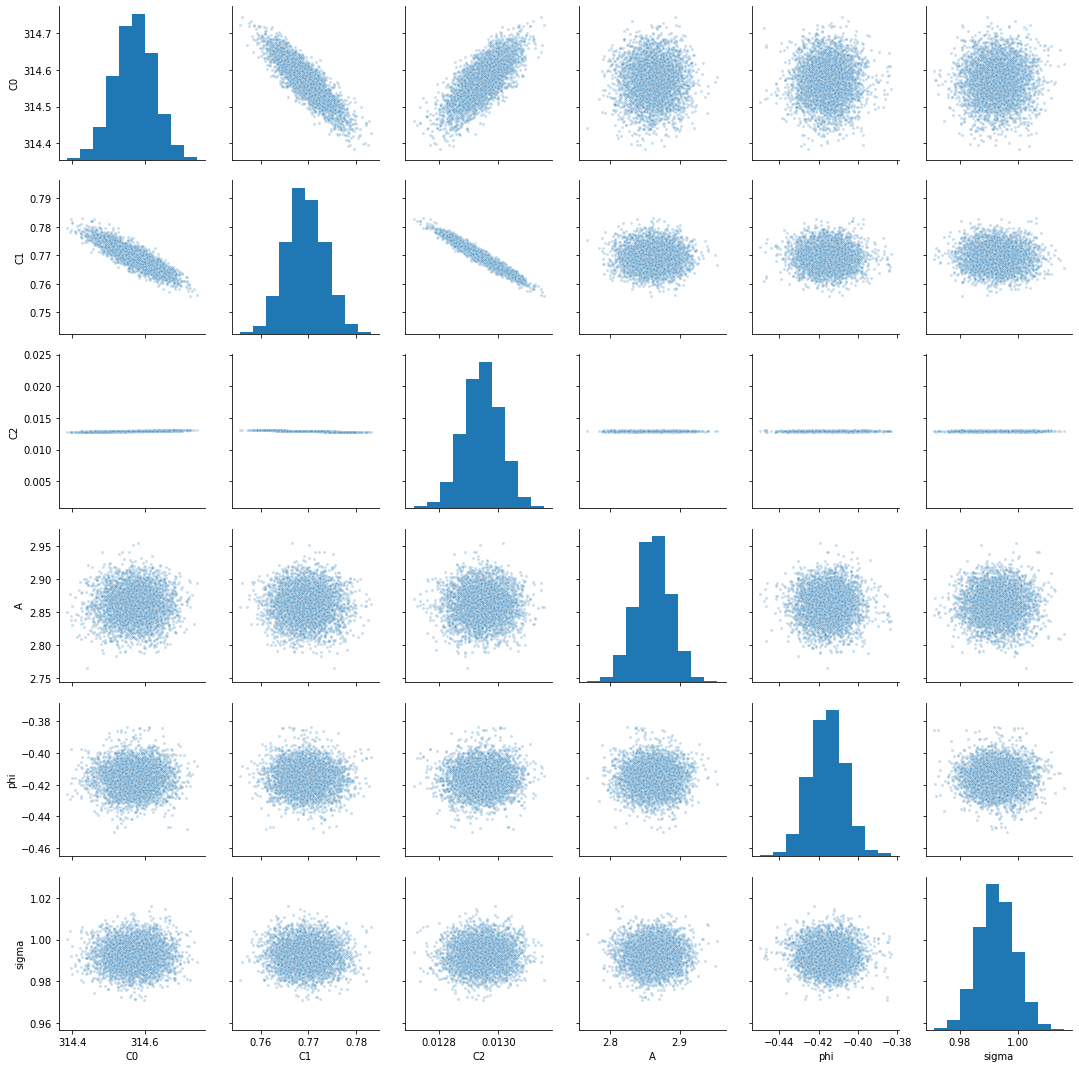

In [115]:
# Make pair plot of the posteriors over all parameters of the model.
df = pd.DataFrame(
    data=np.transpose([samples[param] for param in parameters]),
    columns=parameters)
seaborn.pairplot(df, size=2.5, plot_kws={'marker': '.', 'alpha': 0.25})
plt.show()

Pair plots show a unimodal shape and the samples are very uncorrelated. The samples should be usable.

## Trying with an exponential rather than quadratic term

In [202]:
# model with exponential term rather than quadratic

expstan_code = """
data {
    int<lower=0> n;        // The number of data
    int<lower=0> n_future;
    real x[n];             // The co2 data (observed)
    real<lower=0> time[n];  // Observed time (in years passed)
    real<lower=0> time_future[n_future];  // Unobserved time (in years passed)
}

parameters {
    // _____POLY_____
    real<lower=0> C0;                   // constant
    real<lower=0> C1;                   // x multiplier
    real<lower=0> C2;                   // x^2 multiplier
    
    // _____PERIODIC_____
    real<lower=0> A;           // amplitude
    real phi_x;                // dummy var for phi
    real phi_y;                // "               "
    
    // _____NOISE_____
    real<lower=0> sigma;

}

transformed parameters {
    // atan converts to range [-pi,pi]
    real phi = atan2(phi_x, phi_y); // offset for period
}

model {
    // _____PRIORS_____
    C0 ~ normal(316, 100);
    C1 ~ normal(0, 1);
    C2 ~ normal(0,1);
    A ~ normal(3,2);
    sigma ~ gamma(1, 0.3);
    
    // _____MODEL_____
    for(t in 1:n) {
        x[t] ~ normal(
            C0 + C1*time[t] + C2^time[t] + A*cos(2*pi()*time[t] + phi),
            sigma^2);
    }
}

// Generate the predicted function values for the next n_future steps.
generated quantities {
    real x_future[n_future];
    for(t in 1:n_future) {
        x_future[t] = normal_rng(
            C0 + C1*(time_future[t]) + C2^time[t] + A*cos(2*pi()*time_future[t] + phi),
            sigma^2 + 0.001*t); // arbitrarily add a t factor in uncertainty to show growing uncertainty
    }
}

"""

expstan_model = pystan.StanModel(model_code=expstan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_99fa2872f2f50f96cafe1a907da7e7d0 NOW.


In [203]:
# Run Hamiltonian Monte Carlo using Stan with 4 Markov chains, a 1000 step
# warm-up phase and 1000 step sampling phase for each chain. The warm-up samples
# are discarded, so we are left with 4 x 1000 = 4000 samples.

# This cell will take a minute or two to run.

parameters = ['C0','C1','C2','A','phi','sigma']

expresults = expstan_model.sampling(data=stan_data)
print(expresults.stansummary(pars=parameters))
expsamples = expresults.extract()

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Inference for Stan model: anon_model_99fa2872f2f50f96cafe1a907da7e7d0.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
C0    308.09    2.85   5.64  305.4  305.6 305.72 309.14 326.94      4   1.73
C1      1.41    0.21   0.34   0.29   1.29   1.58   1.58   1.59      3   2.77
C2      0.94    0.05   0.07   0.87   0.89    0.9   0.99   1.07      2   8.46
A        2.6    0.36   0.58   1.62   2.69   2.86   2.93   3.08      3    2.1
phi    -0.26    0.21   0.35  -0.49  -0.44  -0.42  -0.05   0.16      3   1.96
sigma   1.86    0.08   0.35   1.37   1.89    1.9   1.91   2.79     22   1.17

Samples were drawn using NUTS at Wed Dec 18 18:44:38 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


The samples are extremely correlated, will not be using the exponential model, does not look fitting!

# Model Evaluation

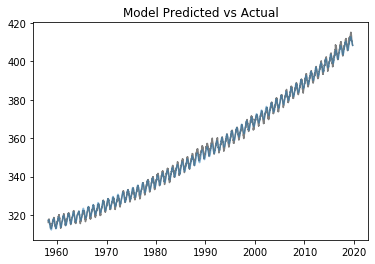

In [205]:
import math
plt.plot(data["date"],data["co2"], 'k-', label='observed',alpha=0.5) # observed data
plt.plot(data["date"],[np.mean(samples["C0"]) + np.mean(samples["C1"])*t + np.mean(samples["C2"])*t**2 + np.mean(samples["A"])*math.cos(2*math.pi*t + np.mean(samples["phi"])) for t in data["years_passed"]],alpha=0.5)
plt.title('Model Predicted vs Actual');


In [139]:
past_model = []
for i in range(4000):
    print(i)
    sample_year = []
    for t in data["years_passed"]:
        sample_year.append(stats.norm.rvs(samples["C0"][i] + samples["C1"][i]*t + samples["C2"][i]*t**2 + samples["A"][i]*math.cos(2*math.pi*t + samples["phi"][i]),
        samples["sigma"][i]**2))
    past_model.append(sample_year)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062


3502
3503
3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701


In [140]:
past_percentiles = np.percentile(past_model, axis=0, q=[2.5, 97.5])

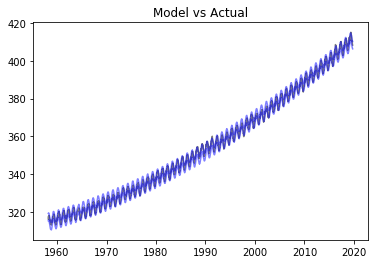

In [143]:
plt.plot(data["date"],data["co2"], 'k-', label='observed',alpha=0.5) # observed data
# prediction interval
plt.plot(data["date"], past_percentiles[0,:],
    'b-', label='prediction 95% interval',alpha=0.5)
plt.plot(data["date"], past_percentiles[1,:],
    'b-', alpha=0.5)
plt.title('Model vs Actual');

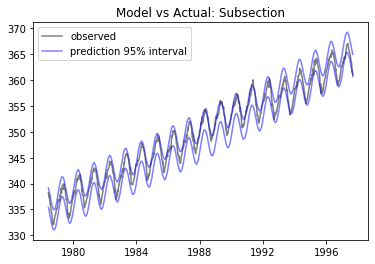

In [207]:
views = 1000
viewe = 2000
plt.plot(data["date"][views:viewe],data["co2"][views:viewe], 'k-', label='observed',alpha=0.5) # observed data
plt.plot(data["date"][views:viewe], past_percentiles[0,:][views:viewe],
    'b-', label='prediction 95% interval',alpha=0.5)
plt.plot(data["date"][views:viewe], past_percentiles[1,:][views:viewe],
    'b-', alpha=0.5)
plt.legend()
plt.title('Model vs Actual: Subsection');

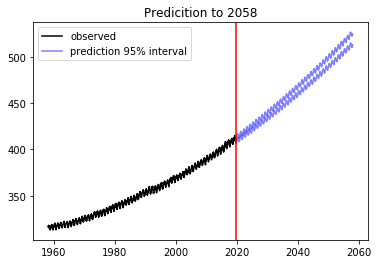

In [208]:
# get 95% percentile for prediction

prediction = samples['x_future'] 
prediction_interval = np.percentile(prediction, axis=0, q=[2.5, 97.5])

plt.plot(data["date"],data["co2"], 'k-', label='observed') # observed data

# prediction interval
plt.plot(pred_dates, prediction_interval[0,:],
    'b-', label='prediction 95% interval',alpha=0.5)
plt.plot(pred_dates, prediction_interval[1,:],
    'b-', alpha=0.5)
plt.axvline(data["date"][len(data["date"])-1], color='red')
plt.legend()
plt.title("Predicition to 2058");

# Posterior Predictive Checks

In [148]:
def sampleTestStat(sample, func, *args):
    ts = []
    for s in sample:
        ts.append(func(s,*args))
    return(ts)

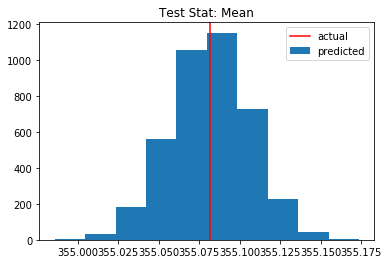

In [209]:
# Testing mean
real_m = np.mean(data["co2"])
sample_m = sampleTestStat(past_model, np.mean)

plt.hist(sample_m,label="predicted")
plt.axvline(real_m, color='red',label="actual")
plt.legend()
plt.title("Test Stat: Mean");

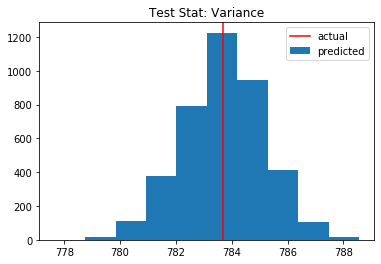

In [210]:
# Testing var
real_v = np.var(data["co2"])
sample_v = sampleTestStat(past_model, np.var)

plt.hist(sample_v,label="predicted")
plt.axvline(real_v, color='red',label="actual")
plt.legend()
plt.title("Test Stat: Variance");

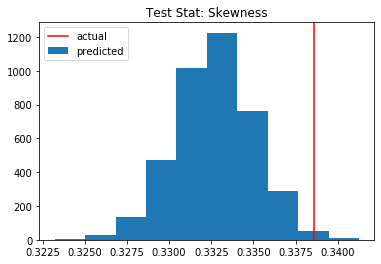

In [211]:
real_s = stats.skew(data["co2"])
sample_s = sampleTestStat(past_model, stats.skew)

plt.hist(sample_s,label="predicted")
plt.axvline(real_s, color='red',label="actual")
plt.legend()
plt.title("Test Stat: Skewness");

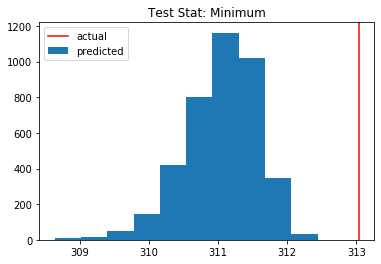

In [212]:
real_min = np.min(data["co2"])
sample_min = sampleTestStat(past_model, np.min)

plt.hist(sample_min,label="predicted")
plt.axvline(real_min, color='red',label="actual")
plt.legend()
plt.title("Test Stat: Minimum");

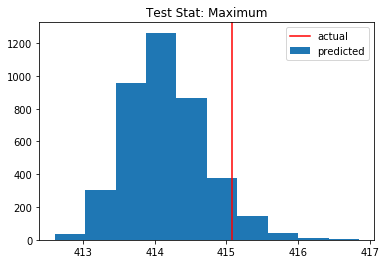

In [213]:
real_max = np.max(data["co2"])
sample_max = sampleTestStat(past_model, np.max)

plt.hist(sample_max,label="predicted")
plt.axvline(real_max, color='red',label="actual")
plt.legend()
plt.title("Test Stat: Maximum");

Generally speaking, it looks like the actual data is a lot more right skewed than my model. Additionally, model minimum and maximum are too low.

It looks like there is some pattern in the data that I am not capturing in my model.

# Predictions based on Model

Carbon Dioxide levels projected until the start of 2058:

In [240]:
from tabulate import tabulate
mean_pred = np.mean(samples['x_future'],axis=0)

print(tabulate([[pred_dates[i].strftime('%Y-%m-%d'),mean_pred[i],prediction_interval[0][i],prediction_interval[1][i]] for i in range(n_future)],headers=['Date', 'Mean','2.5%','97.5%']))


Date           Mean     2.5%    97.5%
----------  -------  -------  -------
2019-10-05  408.185  406.24   410.107
2019-10-12  408.135  406.186  410.091
2019-10-19  408.125  406.165  410.079
2019-10-26  408.187  406.258  410.068
2019-11-02  408.279  406.382  410.288
2019-11-09  408.424  406.533  410.35
2019-11-16  408.572  406.605  410.562
2019-11-23  408.79   406.824  410.741
2019-11-30  409.028  407.168  411.019
2019-12-07  409.317  407.453  411.276
2019-12-14  409.599  407.643  411.646
2019-12-21  409.915  408      411.856
2019-12-28  410.272  408.373  412.275
2020-01-04  410.616  408.616  412.514
2020-01-11  411.009  409.056  412.98
2020-01-18  411.412  409.457  413.426
2020-01-25  411.795  409.857  413.819
2020-02-01  412.155  410.138  414.114
2020-02-08  412.567  410.522  414.469
2020-02-15  412.935  410.948  414.866
2020-02-22  413.287  411.323  415.255
2020-02-29  413.623  411.618  415.682
2020-03-07  413.901  411.934  415.954
2020-03-14  414.189  412.283  416.057
2020-03-21  41

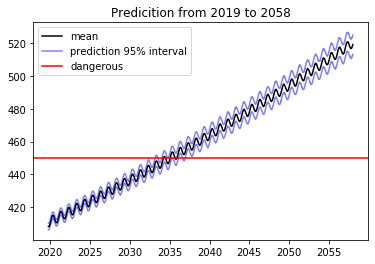

In [247]:
plt.plot(pred_dates, mean_pred, 'k-', label='mean') # observed data

# prediction interval
plt.plot(pred_dates, prediction_interval[0,:],
    'b-', label='prediction 95% interval',alpha=0.5)
plt.plot(pred_dates, prediction_interval[1,:],
    'b-', alpha=0.5)
plt.axhline(450, color='red',label="dangerous")
plt.legend()
plt.title("Predicition from 2019 to 2058");

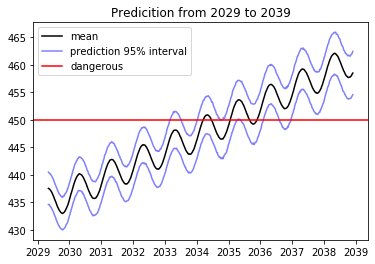

In [254]:
zs = 500
ze = 1000
plt.plot(pred_dates[zs:ze], mean_pred[zs:ze], 'k-', label='mean') # observed data

# prediction interval
plt.plot(pred_dates[zs:ze], prediction_interval[0,zs:ze],
    'b-', label='prediction 95% interval',alpha=0.5)
plt.plot(pred_dates[zs:ze], prediction_interval[1,zs:ze],
    'b-', alpha=0.5)
plt.axhline(450, color='red',label="dangerous")
plt.legend()
plt.title("Predicition from 2029 to 2039");

It is likely that we will reach dangerous levels of carbon dioxide around 2035